# Decision Tree Experiment

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 36.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.3.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Constants

In [8]:
NA_DROP_THRESHOLD = 0.5
CORRELATION_FILTER_THRESHOLD=0.8
KFOLD_N_SPLITS = 3
RANDOM_STATE=42
DECISION_TREE_INITIAL_MAX_DEPTH=5
DATASET_SPLIT_SIZE=0.2

# Load Data

In [2]:
# Load each data table
transactions = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
identities = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

# Merge data tables
df = pd.merge(transactions, identities, on="TransactionID", how="left")

# Free up memory
del transactions
del identities

In [5]:
# Separate features and target values
y_total = df["isFraud"]
X_total = df.drop(columns=["isFraud"])

In [6]:
X_total.shape, y_total.shape

((590540, 433), (590540,))

In [7]:
# The data is extremely imbalanced
y_total.value_counts(normalize=True)

isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=DATASET_SPLIT_SIZE, random_state=RANDOM_STATE)

# Cleaning

### Drop values with high NA content

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropHighNAFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self._feats_to_drop = []
        self.threshold = threshold
    
    def fit(self, X, y=None):
        
        na_dist = X.isna().mean()
        for feat, na_ratio in na_dist.items():
            if na_ratio > self.threshold:
                self._feats_to_drop.append(feat)
        
        return self

    def transform(self, X):
        X = X.copy()

        # Drop features with high NA content
        X.drop(columns=self._feats_to_drop, inplace=True)

        return X

### Fill NA values

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class FillNAWithMedian(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._na_mapping = {}
    
    def fit(self, X, y=None):
        
        for feat in X.columns:
            median = X[feat].median()
            self._na_mapping[feat] = median
        
        return self

    def transform(self, X):
        X = X.copy()

        for feat, value in self._na_mapping.items():
            X[feat] = X[feat].fillna(value)
        
        return X

### Log Pipeline with Cleaning Steps

In [252]:
partial_pipeline = Pipeline([
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
])
log_model(
    run_name="DecisionTree_Cleaning", 
    params={
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    },
    metrics={},
    best_pipeline=partial_pipeline
)

2025/04/27 06:24:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/27 06:24:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_Cleaning at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/11d1ac5e32344e4ab1833a90e8bb8058
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


# Feature Engineering

### Encode Categories Using WOE

In [14]:
import category_encoders

# Find every categorical feature in the data
cat_feats = [feat for feat in X_total.columns if X_total[feat].dtype == "object"]

# Create woe encoder for the features
woe_encoder = category_encoders.WOEEncoder(cols=cat_feats)

In [253]:
partial_pipeline = Pipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
])
log_model(
    run_name="DecisionTree_FeatureEngineering", 
    params={
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    },
    metrics={},
    best_pipeline=partial_pipeline
)

2025/04/27 06:27:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/27 06:27:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_FeatureEngineering at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/7236f8adc76c430fb86da03c243a2d55
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


# Feature Selection

### Correlation Filter

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

# Disclaimer: Part of the following Correlation Filter code is borrowed from Seminar 7 Kaggle notebook
# I modified the code to be used as a pipeline

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self._feats_to_drop = []
        self.threshold = threshold
    
    def fit(self, X, y):
        corr_features = self._find_correlated_features(X, y)
        
        for feats in corr_features:
            if(X[feats[0]].corr(y) < X[feats[1]].corr(y)):
                self._feats_to_drop.append(feats[0])
            else:
                self._feats_to_drop.append(feats[1])

        return self

    def transform(self, X):
        X = X.copy()

        X.drop(columns=self._feats_to_drop, inplace=True)
        
        return X

    def _find_correlated_features(self, X, y):
        result = []
        corr_matrix = X.corr().abs()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > self.threshold:
                    result.append((corr_matrix.columns[i], corr_matrix.columns[j]))

        return result

### RFE

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

classifier = DecisionTreeClassifier(max_depth=DECISION_TREE_INITIAL_MAX_DEPTH, random_state=RANDOM_STATE)
rfe = RFE(estimator=classifier, step=1)

In [257]:
partial_pipeline = Pipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
    ('correlation_filter', CorrelationFilter(threshold=CORRELATION_FILTER_THRESHOLD)),
    ('feature_selector', rfe),
])
log_model(
    run_name="DecisionTree_FeatureSelection", 
    params={
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "correlation_filter_threshold": CORRELATION_FILTER_THRESHOLD,
    "classifier_max_depth": DECISION_TREE_INITIAL_MAX_DEPTH,
    },
    metrics={},
    best_pipeline=partial_pipeline
)

2025/04/27 06:32:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_FeatureSelection at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/de290abbde83422aa5f8be8ccfb74ad6
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


# Training

## Experiment 1.1

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

model = DecisionTreeClassifier(random_state=RANDOM_STATE)
pipeline = Pipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
    ('correlation_filter', CorrelationFilter(threshold=CORRELATION_FILTER_THRESHOLD)),
    ('scaler', StandardScaler()),
    ('feature_selector', RFE(estimator=model, step=1)),
    ('classifier', model),
])

In [20]:
# Specify parameters to try using GridSearch
param_grid = {
    "feature_selector__n_features_to_select": [5, 10, 20],
    "classifier__max_depth": [5, 10],
}

In [327]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [328]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END classifier__max_depth=5, feature_selector__n_features_to_select=5;, score=(train=0.701, test=0.705) total time= 5.8min
[CV 2/3] END classifier__max_depth=5, feature_selector__n_features_to_select=5;, score=(train=0.699, test=0.699) total time= 5.0min
[CV 3/3] END classifier__max_depth=5, feature_selector__n_features_to_select=5;, score=(train=0.731, test=0.721) total time= 5.7min
[CV 1/3] END classifier__max_depth=5, feature_selector__n_features_to_select=10;, score=(train=0.732, test=0.741) total time= 5.7min
[CV 2/3] END classifier__max_depth=5, feature_selector__n_features_to_select=10;, score=(train=0.775, test=0.774) total time= 5.0min
[CV 3/3] END classifier__max_depth=5, feature_selector__n_features_to_select=10;, score=(train=0.726, test=0.714) total time= 5.9min
[CV 1/3] END classifier__max_depth=5, feature_selector__n_features_to_select=20;, score=(train=0.732, test=0.741) total time= 5.6min
[CV 2/3] END

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                        CorrelationFilter(threshold=0.8)),
                                       ('scaler', StandardScaler()),
                                       ('feature_selector',
                                        RFE(estimator=DecisionTreeClassifier(max_depth=5,
                                                                             random_state=42))),
                                       ('classifier',
                                        DecisionTreeClassifier(max_depth=5,
                                                               random_state=42))]),
             param_grid={'classifier__max_depth': [5, 10],
                         'feature_selector__n_features_to_select': [5, 10, 20]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [330]:
grid_search.best_score_

0.8166186038570619

In [331]:
grid_search.best_params_

{'classifier__max_depth': 10, 'feature_selector__n_features_to_select': 20}

## Experiment 1.2

In [137]:
# Specify parameters to try using GridSearch
param_grid = {
    "feature_selector__n_features_to_select": [20],
    "classifier__max_depth": [12, 15],
}

In [142]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

model = DecisionTreeClassifier(max_depth=15, random_state=RANDOM_STATE)
pipeline = Pipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
    ('correlation_filter', CorrelationFilter(threshold=CORRELATION_FILTER_THRESHOLD)),
    ('scaler', StandardScaler()),
    ('feature_selector', RFE(estimator=model, n_features_to_select=20, step=1)),
    ('classifier', model),
])

In [143]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe_encoder',
                 WOEEncoder(cols=['ProductCD', 'card4', 'card6',
                                  'P_emaildomain', 'R_emaildomain', 'M1', 'M2',
                                  'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                                  'id_12', 'id_15', 'id_16', 'id_23', 'id_27',
                                  'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
                                  'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
                                  'DeviceType', ...])),
                ('drop_high_na_feats', DropHighNAFeatures(threshold=0.5)),
                ('fill_na_with_median', FillNAWithMedian()),
                ('correlation_filter', CorrelationFilter(threshold=0.8)),
                ('scaler', StandardScaler()),
                ('feature_selector',
                 RFE(estimator=DecisionTreeClassifier(max_depth=15,
                                                      random_state=42),
                     n_features_to_select=20)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=15, random_state=42))])

In [144]:
# Predict probabilities
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_test_score = auc(fpr, tpr)

In [145]:
auc_test_score

0.8208344133102746

In [146]:
# Predict probabilities
y_prob = pipeline.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_prob)
auc_train_score = auc(fpr, tpr)

In [147]:
auc_train_score

0.8633249269569131

In [148]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    "correlation_filter_threshold": CORRELATION_FILTER_THRESHOLD,
    "feature_selector__n_features_to_select": 20,
    "classifier__max_depth": 15,
    "oversampler": "smote"
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'kfold_n_splits': 3,
 'correlation_filter_threshold': 0.8,
 'feature_selector__n_features_to_select': 20,
 'classifier__max_depth': 15,
 'oversampler': 'smote'}

In [149]:
metrics = {
    "auc_train_score": auc_train_score,
    "auc_test_score": auc_test_score
}
metrics

{'auc_train_score': 0.8633249269569131, 'auc_test_score': 0.8208344133102746}

In [150]:
log_custom_pymodel(
    run_name="DecisionTree_Overfit",
    params=params,
    metrics=metrics,
    best_pipeline=pipeline,
)

2025/04/29 15:18:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_Overfit at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/5689c6e2a491453bbe78d2163cf0b334
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


## Helper functions

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc(model, X, y):
    
    # Predict probabilities
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    
    plt.title("ROC Curve on Training Set")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(fpr, tpr, color="blue")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"decision_tree_roc_curve.png")
    plt.show()

    # Draw Mirrored ROC curve
    tnr = 1 - fpr
    plt.figure(figsize=(10, 8))
    
    plt.title("Mirrored ROC Curve on Training Set")
    plt.xlabel('True Negative Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(tnr, tpr, color="red")
    plt.plot([0, 1], [1, 0], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"decision_tree_roc_curve_mirrored.png")
    plt.show()

In [34]:
def get_metrics(grid_search):
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Get the best result from the grid search
    best_result = results.sort_values(by="rank_test_score").iloc[0].to_dict()

    # Remove parameter values
    keys_to_drop = []
    for key in best_result.keys():
        if key.startswith("param"):
            keys_to_drop.append(key)
    
    for key in keys_to_drop:
        del best_result[key]

    del best_result["rank_test_score"]

    return best_result

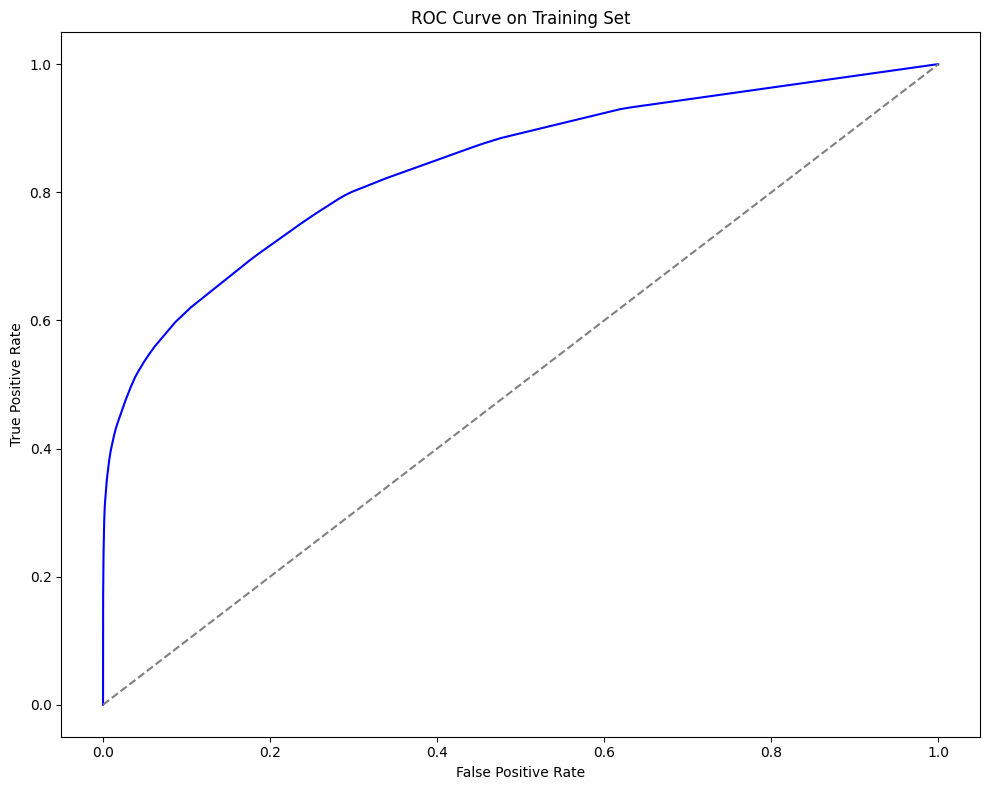

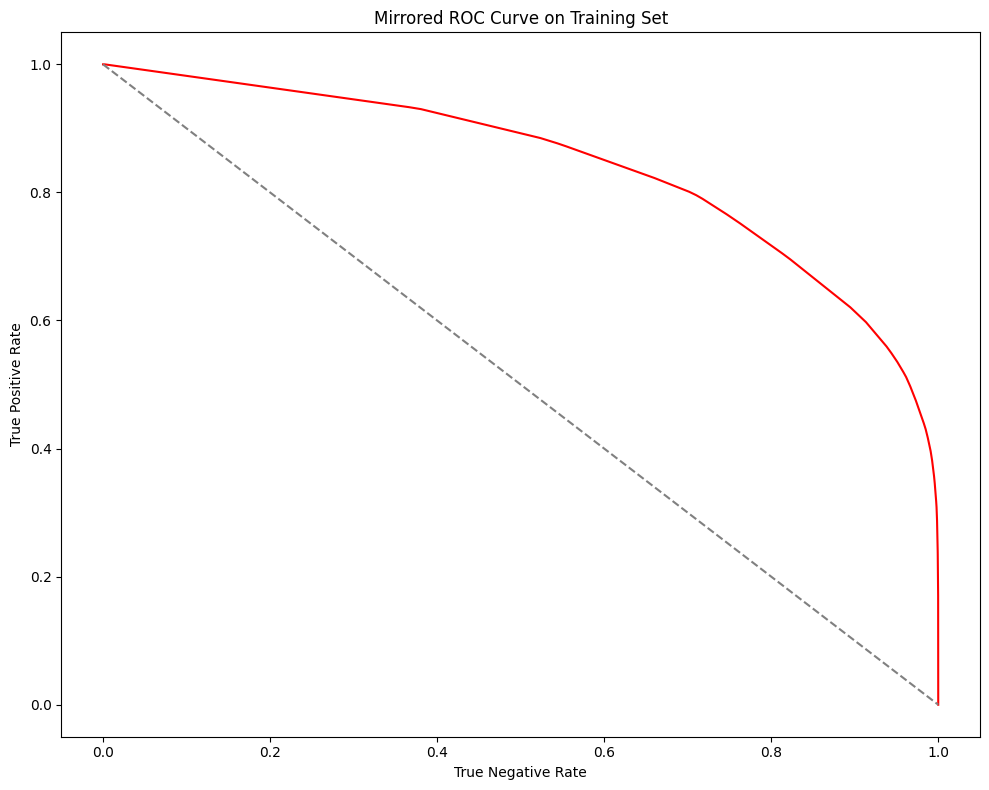

In [333]:
best_pipeline = grid_search.best_estimator_
plot_roc(best_pipeline, X, y)

In [33]:
# https://mlflow.org/docs/latest/traditional-ml/creating-custom-pyfunc/notebooks/override-predict/

class ProbabilityModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def load_context(self, context):
        pass

    def predict(self, context, model_input, params=None):
        return self.model.predict_proba(model_input)[:, 1]

/usr/local/lib/python3.11/dist-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


# Log Experiments

In [30]:
!pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 33.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 94.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      S

In [31]:
import dagshub
dagshub.auth.add_app_token('ed22b8f88bed7c968c7425f62448b33703f4e094')
dagshub.init(repo_owner='vvaza22', repo_name='ml-assignment-2', mlflow=True)

Accessing as vvaza22

Initialized MLflow to track repo "vvaza22/ml-assignment-2"

Repository vvaza22/ml-assignment-2 initialized!

In [32]:
import mlflow

def log_model(run_name, params, metrics, best_pipeline, figures=[]):
    mlflow.set_experiment("DecisionTree_Training")
    mlflow.set_tracking_uri("https://dagshub.com/vvaza22/ml-assignment-2.mlflow")
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(best_pipeline, "DecisionTree")
        for artifact in figures:
            mlflow.log_artifact(f"/kaggle/working/{artifact}")

def log_custom_pymodel(run_name, params, metrics, best_pipeline, figures=[]):
    mlflow.set_experiment("DecisionTree_Training")
    mlflow.set_tracking_uri("https://dagshub.com/vvaza22/ml-assignment-2.mlflow")
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.pyfunc.log_model("DecisionTree", python_model=ProbabilityModel(best_pipeline))
        for artifact in figures:
            mlflow.log_artifact(f"/kaggle/working/{artifact}")

In [335]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "correlation_filter_threshold": CORRELATION_FILTER_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}

In [336]:
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'correlation_filter_threshold': 0.8,
 'kfold_n_splits': 3,
 'classifier__max_depth': 10,
 'feature_selector__n_features_to_select': 20}

In [338]:
metrics = get_metrics(grid_search)

In [339]:
metrics

{'mean_fit_time': 316.3488266468048,
 'std_fit_time': 20.666967393341196,
 'mean_score_time': 4.1458189487457275,
 'std_score_time': 0.022005670918334257,
 'split0_test_score': 0.827606575293199,
 'split1_test_score': 0.8147468836251535,
 'split2_test_score': 0.807502352652833,
 'mean_test_score': 0.8166186038570619,
 'std_test_score': 0.008313540940868818,
 'split0_train_score': 0.8304237463258501,
 'split1_train_score': 0.8313961930594842,
 'split2_train_score': 0.8234814386355539,
 'mean_train_score': 0.8284337926736294,
 'std_train_score': 0.003524274965745535}

In [340]:
best_pipeline = grid_search.best_estimator_

In [341]:
log_model(
    run_name="DecisionTree_Model",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["decision_tree_roc_curve.png", "decision_tree_roc_curve_mirrored.png"]
)

2025/04/27 10:59:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_Model at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/3857e44a53ad4b178179d15d1b2e3eb6
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


In [342]:
log_custom_pymodel(
    run_name="DecisionTree_Prob_Model",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["decision_tree_roc_curve.png", "decision_tree_roc_curve_mirrored.png"]
)

2025/04/27 10:59:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_Prob_Model at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/26e34af9277844d49e150a7dece44cb4
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


## Experiment 2: No Preprocessing

In [22]:
# Specify parameters to try using GridSearch
param_grid = {
    "classifier__max_depth": [5, 10],
}

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=RANDOM_STATE)
pipeline = Pipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
    ('classifier', model),
])

In [24]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [25]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END classifier__max_depth=5;, score=(train=0.765, test=0.764) total time=  29.8s
[CV 2/3] END classifier__max_depth=5;, score=(train=0.751, test=0.744) total time=  29.0s
[CV 3/3] END classifier__max_depth=5;, score=(train=0.749, test=0.747) total time=  28.4s
[CV 1/3] END classifier__max_depth=10;, score=(train=0.844, test=0.828) total time=  35.7s
[CV 2/3] END classifier__max_depth=10;, score=(train=0.848, test=0.837) total time=  35.3s
[CV 3/3] END classifier__max_depth=10;, score=(train=0.850, test=0.844) total time=  35.1s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'id_38', 'DeviceType', ...])),
                                       ('drop_high_na_feats',
                                        DropHighNAFeatures(threshold=0.5)),
                                       ('fill_na_with_median',
                                        FillNAWithMedian()),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [5, 10]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [42]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'kfold_n_splits': 3,
 'classifier__max_depth': 10}

In [39]:
from sklearn.metrics import roc_auc_score

# Calculate validation score
best_pipeline = grid_search.best_estimator_
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
auc_test_score = roc_auc_score(y_test, y_prob)
auc_test_score

0.8476822053082355

In [40]:
metrics = get_metrics(grid_search)
metrics["validation_score"] = auc_test_score
metrics

{'mean_fit_time': 32.26636830965678,
 'std_fit_time': 0.27821381101572196,
 'mean_score_time': 3.113628307978312,
 'std_score_time': 0.03195553603879113,
 'split0_test_score': 0.8276780758572233,
 'split1_test_score': 0.8374050134024525,
 'split2_test_score': 0.8444701917563782,
 'mean_test_score': 0.8365177603386846,
 'std_test_score': 0.006884000900253497,
 'split0_train_score': 0.8438187972399872,
 'split1_train_score': 0.847792686257192,
 'split2_train_score': 0.8502098490160314,
 'mean_train_score': 0.8472737775044035,
 'std_train_score': 0.0026348099768686204,
 'validation_score': 0.8476822053082355}

In [43]:
log_custom_pymodel(
    run_name="DecisionTree_Prob_Model_NoPreprocessing",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
)

2025/04/29 12:18:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_Prob_Model_NoPreprocessing at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/1691e9d95ace4586963589c05d5e2468
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


In [46]:
best_classifier = grid_search.best_estimator_.named_steps["classifier"]
feat_importances = best_classifier.feature_importances_

In [57]:
X_mod = category_encoders.WOEEncoder(cols=cat_feats).fit_transform(X_train, y_train)
X_mod = DropHighNAFeatures(threshold=NA_DROP_THRESHOLD).fit_transform(X_mod)

In [58]:
len(X_mod.columns), len(feat_importances)

(241, 241)

In [59]:
feat_table = pd.DataFrame({
    'feature': X_mod.columns,
    'importance': feat_importances
})

In [63]:
feat_table.sort_values(by='importance', ascending=False).head(20)

,feature,importance
88,V45,0.198000
14,C1,0.150420
240,DeviceInfo,0.123121
26,C13,0.065514
20,C7,0.064543
27,C14,0.048428
13,R_emaildomain,0.029772
219,V317,0.023280
15,C2,0.022764
5,card2,0.016441


In [89]:
imp_feats = feat_table.sort_values(by='importance', ascending=False).head(50)["feature"].to_list()
imp_feats

['V45',
 'C1',
 'DeviceInfo',
 'C13',
 'C7',
 'C14',
 'R_emaildomain',
 'V317',
 'C2',
 'card2',
 'card3',
 'V87',
 'V283',
 'C11',
 'id_33',
 'C8',
 'TransactionAmt',
 'V62',
 'V296',
 'P_emaildomain',
 'TransactionID',
 'TransactionDT',
 'V313',
 'id_31',
 'D2',
 'D4',
 'ProductCD',
 'card6',
 'D15',
 'V291',
 'D3',
 'card1',
 'V308',
 'card4',
 'V12',
 'C4',
 'id_37',
 'C6',
 'V112',
 'V306',
 'V282',
 'V84',
 'V40',
 'V279',
 'V44',
 'V294',
 'V315',
 'M4',
 'addr1',
 'D1']

In [90]:
len(imp_feats)

50

In [91]:
from sklearn.base import BaseEstimator, TransformerMixin

class SelectFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.features]

In [92]:
# Specify parameters to try using GridSearch
param_grid = {
    "classifier__max_depth": [7, 10, 12],
    "classifier__max_features": [25],
}

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=RANDOM_STATE)
pipeline = Pipeline([
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na_with_median', FillNAWithMedian()),
    ('select_features', SelectFeatures(imp_feats)),
    ('classifier', model),
])

In [96]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [97]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END classifier__max_depth=7, classifier__max_features=25;, score=(train=0.810, test=0.803) total time=  24.9s
[CV 2/3] END classifier__max_depth=7, classifier__max_features=25;, score=(train=0.808, test=0.803) total time=  23.7s
[CV 3/3] END classifier__max_depth=7, classifier__max_features=25;, score=(train=0.807, test=0.807) total time=  23.6s
[CV 1/3] END classifier__max_depth=10, classifier__max_features=25;, score=(train=0.847, test=0.828) total time=  24.8s
[CV 2/3] END classifier__max_depth=10, classifier__max_features=25;, score=(train=0.849, test=0.833) total time=  24.8s
[CV 3/3] END classifier__max_depth=10, classifier__max_features=25;, score=(train=0.853, test=0.841) total time=  24.2s
[CV 1/3] END classifier__max_depth=12, classifier__max_features=25;, score=(train=0.849, test=0.820) total time=  25.1s
[CV 2/3] END classifier__max_depth=12, classifier__max_features=25;, score=(train=0.865, test=0.839) tot

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                                                 'V283', 'C11',
                                                                 'id_33', 'C8',
                                                                 'TransactionAmt',
                                                                 'V62', 'V296',
                                                                 'P_emaildomain',
                                                                 'TransactionID',
                                                                 'TransactionDT',
                                                                 'V313',
                                                                 'id_31', 'D2',
                                                                 'D4',
                                                                 'ProductCD',
                                                                 'card6', 'D15',
                                                                 'V291', ...])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [7, 10, 12],
                         'classifier__max_features': [25]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [98]:
grid_search.best_score_

0.8340279896868816

In [99]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'kfold_n_splits': 3,
 'classifier__max_depth': 10,
 'classifier__max_features': 25}

In [100]:
from sklearn.metrics import roc_auc_score

# Calculate validation score
best_pipeline = grid_search.best_estimator_
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
auc_test_score = roc_auc_score(y_test, y_prob)
auc_test_score

0.8456597789788941

In [101]:
metrics = get_metrics(grid_search)
metrics["validation_score"] = auc_test_score
metrics

{'mean_fit_time': 21.58895166714986,
 'std_fit_time': 0.27032922411963034,
 'mean_score_time': 2.989551623662313,
 'std_score_time': 0.01017615693642357,
 'split0_test_score': 0.8278436911506771,
 'split1_test_score': 0.8331783817434714,
 'split2_test_score': 0.8410618961664966,
 'mean_test_score': 0.8340279896868816,
 'std_test_score': 0.005429647699018687,
 'split0_train_score': 0.8469772286452988,
 'split1_train_score': 0.8485397470482309,
 'split2_train_score': 0.8527838519810097,
 'mean_train_score': 0.8494336092248465,
 'std_train_score': 0.002453359714594606,
 'validation_score': 0.8456597789788941}

In [102]:
log_custom_pymodel(
    run_name="DecisionTree_ImpFeats_NoPreprocessing",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
)

2025/04/29 13:10:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_ImpFeats_NoPreprocessing at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/524405385115479cb13a1f25dfb60243
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


## Experiment 3: Imbalanced Learn

In [104]:
# Specify parameters to try using GridSearch
param_grid = {
    "classifier__max_depth": [7, 10, 12],
    "classifier__max_features": [25],
}

In [107]:
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

model = DecisionTreeClassifier(random_state=RANDOM_STATE)
pipeline = ImbalancedPipeline(steps=[
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na', FillNAWithMedian()),
    ('select_features', SelectFeatures(imp_feats)),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', model),
])

In [108]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [109]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END classifier__max_depth=7, classifier__max_features=25;, score=(train=0.832, test=0.825) total time=  36.8s
[CV 2/3] END classifier__max_depth=7, classifier__max_features=25;, score=(train=0.824, test=0.824) total time=  34.1s
[CV 3/3] END classifier__max_depth=7, classifier__max_features=25;, score=(train=0.835, test=0.831) total time=  34.3s
[CV 1/3] END classifier__max_depth=10, classifier__max_features=25;, score=(train=0.858, test=0.842) total time=  37.9s
[CV 2/3] END classifier__max_depth=10, classifier__max_features=25;, score=(train=0.847, test=0.834) total time=  37.6s
[CV 3/3] END classifier__max_depth=10, classifier__max_features=25;, score=(train=0.857, test=0.844) total time=  35.3s
[CV 1/3] END classifier__max_depth=12, classifier__max_features=25;, score=(train=0.874, test=0.834) total time=  38.9s
[CV 2/3] END classifier__max_depth=12, classifier__max_features=25;, score=(train=0.872, test=0.842) tot

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                                                 'TransactionAmt',
                                                                 'V62', 'V296',
                                                                 'P_emaildomain',
                                                                 'TransactionID',
                                                                 'TransactionDT',
                                                                 'V313',
                                                                 'id_31', 'D2',
                                                                 'D4',
                                                                 'ProductCD',
                                                                 'card6', 'D15',
                                                                 'V291', ...])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [7, 10, 12],
                         'classifier__max_features': [25]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [110]:
grid_search.best_score_

0.840376626155647

In [111]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'kfold_n_splits': 3,
 'classifier__max_depth': 12,
 'classifier__max_features': 25}

In [112]:
from sklearn.metrics import roc_auc_score

# Calculate validation score
best_pipeline = grid_search.best_estimator_
y_prob = best_pipeline.predict_proba(X_test)[:, 1]
auc_test_score = roc_auc_score(y_test, y_prob)
auc_test_score

0.8495009514852537

In [113]:
metrics = get_metrics(grid_search)
metrics["validation_score"] = auc_test_score
metrics

{'mean_fit_time': 35.01933232943217,
 'std_fit_time': 0.8387095157080745,
 'mean_score_time': 3.2362987200419107,
 'std_score_time': 0.04658187300680458,
 'split0_test_score': 0.83405288526386,
 'split1_test_score': 0.8423068246739908,
 'split2_test_score': 0.84477016852909,
 'mean_test_score': 0.840376626155647,
 'std_test_score': 0.004583251384985511,
 'split0_train_score': 0.8736758265587924,
 'split1_train_score': 0.8717025348010399,
 'split2_train_score': 0.8733733629119638,
 'mean_train_score': 0.872917241423932,
 'std_train_score': 0.0008677577231719046,
 'validation_score': 0.8495009514852537}

In [114]:
log_custom_pymodel(
    run_name="DecisionTree_ImbLearn_ImpFeats",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
)

2025/04/29 13:24:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_ImbLearn_ImpFeats at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/2781e3c59a174f93ac8c0225b09e8141
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0


## Experiment 4: Imbalanced Learn + Preprocessing

In [123]:
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

model = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)
pipeline = ImbalancedPipeline(steps=[
    ('woe_encoder', woe_encoder),
    ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
    ('fill_na', FillNAWithMedian()),
    ('correlation_filter', CorrelationFilter(threshold=CORRELATION_FILTER_THRESHOLD)),
    ('feature_selector', RFE(estimator=model, n_features_to_select=20, step=1)),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', model),
])

In [124]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe_encoder',
                 WOEEncoder(cols=['ProductCD', 'card4', 'card6',
                                  'P_emaildomain', 'R_emaildomain', 'M1', 'M2',
                                  'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                                  'id_12', 'id_15', 'id_16', 'id_23', 'id_27',
                                  'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
                                  'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
                                  'DeviceType', ...])),
                ('drop_high_na_feats', DropHighNAFeatures(threshold=0.5)),
                ('fill_na', FillNAWithMedian()),
                ('correlation_filter', CorrelationFilter(threshold=0.8)),
                ('feature_selector',
                 RFE(estimator=DecisionTreeClassifier(max_depth=10,
                                                      random_state=42),
                     n_features_to_select=20)),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

In [125]:
# Predict probabilities
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_test_score = auc(fpr, tpr)

In [126]:
auc_test_score

0.8317566819010804

In [127]:
# Predict probabilities
y_prob = pipeline.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_prob)
auc_train_score = auc(fpr, tpr)

In [128]:
auc_train_score

0.8395134427310299

In [131]:
metrics = {
    "auc_train_score": auc_train_score,
    "auc_test_score": auc_test_score
}
metrics

{'auc_train_score': 0.8395134427310299, 'auc_test_score': 0.8317566819010804}

In [135]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    "correlation_filter_threshold": CORRELATION_FILTER_THRESHOLD,
    "feature_selector__n_features_to_select": 20,
    "classifier__max_depth": 10,
    "oversampler": "smote"
}
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'kfold_n_splits': 3,
 'correlation_filter_threshold': 0.8,
 'feature_selector__n_features_to_select': 20,
 'classifier__max_depth': 10,
 'oversampler': 'smote'}

In [136]:
log_custom_pymodel(
    run_name="DecisionTree_ImbLearn_With_Preprocessing",
    params=params,
    metrics=metrics,
    best_pipeline=pipeline,
)

2025/04/29 14:36:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DecisionTree_ImbLearn_With_Preprocessing at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0/runs/255ab7353a6a4a1b9852b94331314d96
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/0
